In [3]:
import numpy as np
import matplotlib.pyplot as plt


class Map:
    
    def __init__(self, pos: tuple, shape: tuple, scale: float) -> None:
        self.pos = np.array(pos, dtype=np.int16)
        self.array = np.zeros(shape, dtype=np.uint16)
        self.scale = scale
    
    
    def __contains__(self, value) -> bool:
        i = np.array(value)
        low, high = self.limits()
        return all(i >= low) and all(i < high)
    
    
    def __getitem__(self, key) -> int | np.ndarray:
        if key not in self:
            raise IndexError(f'За границами карты {key}')
        i = np.array(key)
        index = i - self.pos[:i.size]
        return self.array[*index]
    
    
    def __setitem__(self, key, value: int):
        if key not in self:
            raise IndexError(f'За границами карты {key}')
        i = np.array(key)
        index = i - self.pos[:i.size]
        self.array[*index] = value
    
    
    def limits(self) -> tuple[np.ndarray, np.ndarray]:
        return self.pos, self.pos + self.array.shape
    
    
    def update(self, other):
        if self.scale != other.scale:
            raise ValueError(f'Масштаб карт при сложении отличается: {self.scale} и {other.scale}')
        low1, high1 = self.limits()
        low2, high2 = other.limits()
        new_pos = np.min(np.vstack((low1, low2)), axis=0)
        new_high = np.max(np.vstack((high1, high2)), axis=0)
        new_array = np.zeros(new_high-new_pos, dtype=np.uint16)
        new_array[*[slice(l, h) for l, h in zip(low1-new_pos, low1-new_pos + np.array(self.array.shape))]] += self.array
        new_array[*[slice(l, h) for l, h in zip(low2-new_pos, low2-new_pos + np.array(other.array.shape))]] += other.array
        self.pos = new_pos
        self.array = new_array
        

    def show(self):
        x_min, y_max, x_max, y_min = np.concatenate(self.limits())*self.scale
        plt.imshow(self.array, cmap='gray_r', extent=[y_max, y_min, x_max, x_min])
        plt.gca().set_aspect('equal')
        plt.colorbar()
        plt.grid(which='both')


def new_measurement(coords: np.ndarray, data: np.ndarray, scale: float) -> Map:
    x, y, rot = coords
    angle = np.linspace(-2*np.pi/3, 2*np.pi/3, len(data))
    data[data == 5.6] = np.nan
    data[data < 0.3] = np.nan
    xs = np.array([x + data * np.cos(rot-angle)]).transpose()
    ys = np.array([y + data * np.sin(rot-angle)]).transpose()
    points = np.hstack((xs, ys))
    points = points[~np.isnan(points).any(axis=1)]
    decomposed = (points // np.array([scale, scale])).astype(np.int16)
    decoposed_coords, counts = np.unique(decomposed, axis=0, return_counts=True)
    x_min, y_min, x_max, y_max = *decoposed_coords.min(axis=0), *decoposed_coords.max(axis=0)
    size = np.array([x_max - x_min + 1, y_max - y_min + 1])
    TOPLEFT = np.array([x_min, y_min])
    cell_map = np.zeros(size, dtype=np.uint16)
    for coord, n in zip(decoposed_coords, counts):
        cell_map[*(coord-TOPLEFT)] = n
    cell_map = cell_map.transpose()
    obj = Map(tuple(reversed(TOPLEFT)), cell_map.shape, scale)
    obj.array = cell_map
    return obj

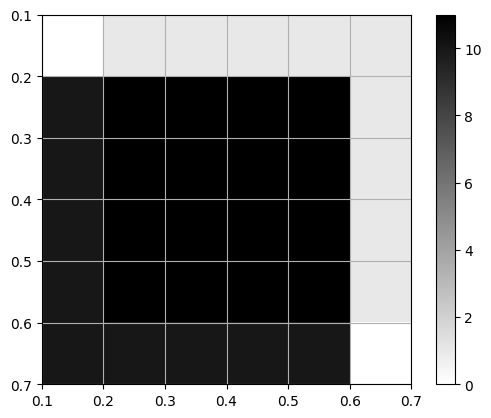

In [88]:
a = Map((1, 2), (5, 5), 0.1)
b = Map((2, 1), (5, 5), 0.1)
a.array += 1
b.array += 10
a.update(b)
a.show()

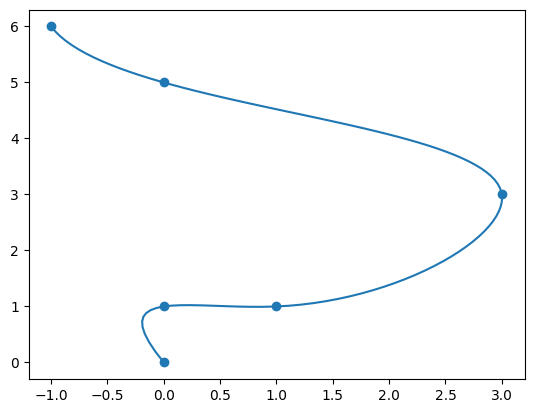

In [57]:
import numpy as np
import scipy.interpolate as interp

def interpolate_polyline(polyline, num_points):
    tck, u = interp.splprep(polyline.T, s=0)
    u = np.linspace(0.0, 1.0, num_points)
    return np.array(interp.splev(u, tck)).transpose()

A = np.array([[0, 0], [0, 1], [1, 1], [3, 3], [0, 5], [-1, 6]])

B = interpolate_polyline(A, 100)
plt.plot(*B.transpose())
plt.scatter(*A.transpose())

In [3]:
import numpy as np

trajectory = [np.array([0, 0]),
              np.array([0, 1]),
              np.array([2, 2]),
              np.array([4, 5]),
              np.array([6, 6])]


np.vstack([np.linspace(trajectory[i], point, 5, endpoint=False) for i, point in enumerate(trajectory[1:])])

array([[0. , 0. ],
       [0. , 0.2],
       [0. , 0.4],
       [0. , 0.6],
       [0. , 0.8],
       [0. , 1. ],
       [0.4, 1.2],
       [0.8, 1.4],
       [1.2, 1.6],
       [1.6, 1.8],
       [2. , 2. ],
       [2.4, 2.6],
       [2.8, 3.2],
       [3.2, 3.8],
       [3.6, 4.4],
       [4. , 5. ],
       [4.4, 5.2],
       [4.8, 5.4],
       [5.2, 5.6],
       [5.6, 5.8]])

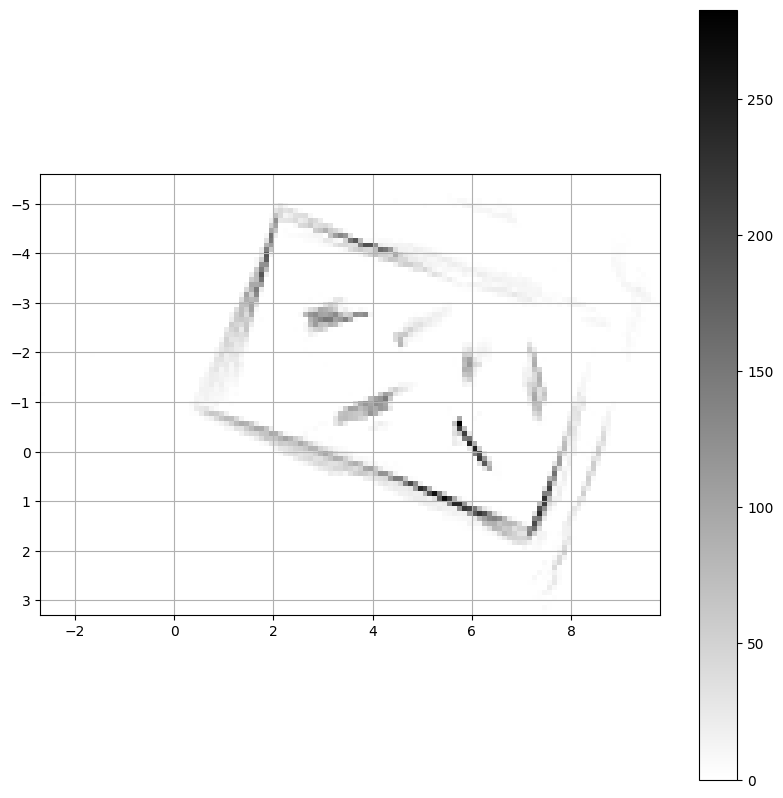

In [5]:
SCALE = 0.1

plt.figure(figsize=(10, 10))
with open("examples/examp7.txt") as file:
    for i, line in enumerate(file):
        c, d = line.split("; ")
        coords = np.array([float(number) for number in c.split(", ")])
        data = np.array([float(number) for number in d.split(", ")])
        if i == 0:
            a = new_measurement(coords, data, SCALE)
        else:
            a.update(new_measurement(coords, data, SCALE))
a.show()

Scheme viz

In [2]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import schematics

class Sim:
    '''Represents sim. Use Sim.sim.{command}() to send commands to sim.'''
    
    client = RemoteAPIClient()
    sim = client.getObject('sim')
    client.setStepping(False)
    verbose = True  


scheme = schematics.open_scheme('schemes/default_scheme.json')

for coords, rot, shape in scheme.iterator():
    cube = Sim.sim.createPrimitiveShape(Sim.sim.primitiveshape_cuboid, list(shape))
    Sim.sim.setObjectPosition(cube, Sim.sim.handle_world, list(coords))
    Sim.sim.setObjectOrientation(cube, Sim.sim.handle_world, [0, 0, rot])

ModuleNotFoundError: No module named 'schematics'

In [6]:
def convert_from_uvd(u, v, d, f, c):
    x = (u - c[1]) * d / f
    y = (v - c[0]) * d / f
    z = d
    return np.array([x, y, z])
    

def new_measurement(coords: np.ndarray, data: np.ndarray, scale: float) -> Map:
    x, y, rot = coords
    angle = np.linspace(3*np.pi/8, -3*np.pi/8, len(data))
    data /= np.cos(angle)
    xs = np.array([x + data * np.cos(rot-angle)]).transpose()
    ys = np.array([y + data * np.sin(rot-angle)]).transpose()
    points = np.hstack((xs, ys))
    points = points[~np.isnan(points).any(axis=1)]
    decomposed = (points // np.array([scale, scale])).astype(np.int16)
    decoposed_coords, counts = np.unique(decomposed, axis=0, return_counts=True)
    x_min, y_min, x_max, y_max = *decoposed_coords.min(axis=0), *decoposed_coords.max(axis=0)
    size = np.array([x_max - x_min + 1, y_max - y_min + 1])
    TOPLEFT = np.array([x_min, y_min])
    cell_map = np.zeros(size, dtype=np.uint16)
    for coord, n in zip(decoposed_coords, counts):
        cell_map[*(coord-TOPLEFT)] = n
    cell_map = cell_map.transpose()
    obj = Map(tuple(reversed(TOPLEFT)), cell_map.shape, scale)
    obj.array = cell_map
    return obj

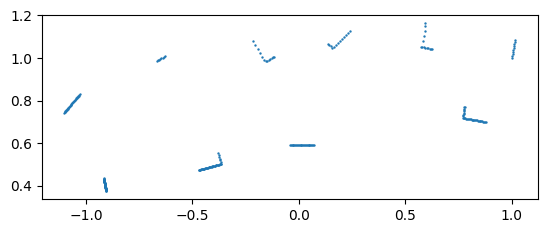

In [30]:
import struct
import time
SCALE = 0.01

Sim.sim.startSimulation()
time.sleep(0.5)
lidar = Sim.sim.getObject('/youBot/Lidar')
cloud = np.empty((3, 0))

start = time.time()
# while time.time()-start < 5:
depth, res = Sim.sim.getVisionSensorDepth(lidar)
pos = Sim.sim.getObjectPosition(lidar, Sim.sim.handle_world)
azimuth = Sim.sim.getObjectOrientation(lidar, Sim.sim.handle_world)
d = [struct.unpack('f', depth[i:i+4])[0] for i in range(0, len(depth), 4)]
data = np.array(d).reshape(res)
data[data > 0.99] = np.nan
data = data * (2 - 1e-4) + 1e-4
cloud = np.array([convert_from_uvd(u, v, data[v, u], data.shape[1]/2/np.tan(3*np.pi/8), np.array(data.shape)/2) for u in range(data.shape[1]) for v in range(data.shape[0])]).transpose()
cloud = cloud[:, ~np.isnan(cloud).any(axis=0)]

Sim.sim.stopSimulation()

plt.gca().set_aspect('equal')
plt.scatter(*cloud[[0, 2]], s=0.5)

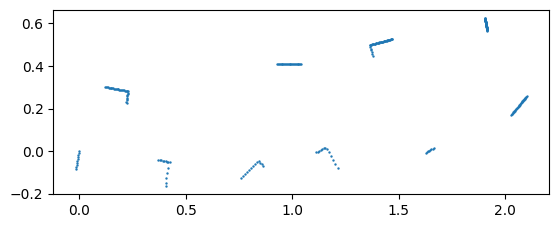

In [31]:
a = np.pi
matrix_z = np.array([[np.cos(a), -np.sin(a), 0.],
                     [np.sin(a), np.cos(a), 0.],
                     [0., 0., 1.]])

x, y, z = cloud
global_cloud = np.array([x, z, y])
cloud = (np.dot(global_cloud.transpose(), matrix_z) + np.array([1, 1, 0])).transpose()
plt.gca().set_aspect('equal')
plt.scatter(*cloud[:2], s=0.5)

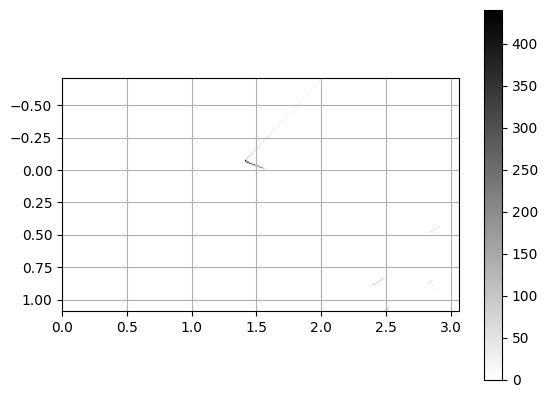

In [45]:
import struct
import time
start = time.time()
SCALE = 0.01

Sim.sim.startSimulation()
lidar = Sim.sim.getObject('/youBot/Lidar')
world_map = Map(Sim.sim.getObjectPosition(lidar, Sim.sim.handle_world)[:2], (0, 0), SCALE)

while time.time()-start < 5:
    depth, res = Sim.sim.getVisionSensorDepth(lidar)
    pos = Sim.sim.getObjectPosition(lidar, Sim.sim.handle_world)
    azimuth = Sim.sim.getObjectOrientation(lidar, Sim.sim.handle_world)
    d = [struct.unpack('f', depth[i:i+4])[0] for i in range(0, len(depth), 4)]
    data = np.array(d).reshape(res[1])*2 + 1e-04
    data[data > 1.9] = np.nan
    if np.isnan(data).all():
        continue
    world_map.update(new_measurement(coords, data, SCALE))
    time.sleep(0.1)

Sim.sim.stopSimulation()

world_map.show()

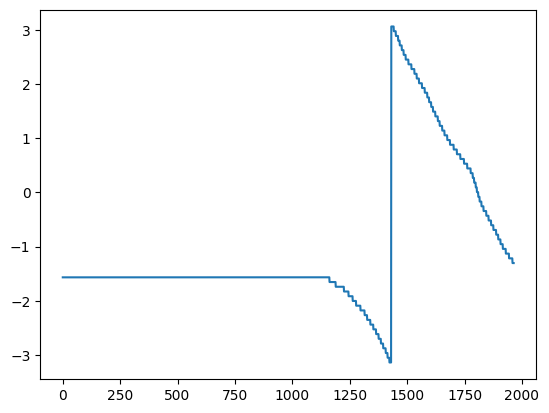

In [11]:
import time
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import matplotlib.pyplot as plt

class Sim:
    '''Represents sim. Use Sim.sim.{command}() to send commands to sim.'''
    
    client = RemoteAPIClient()
    sim = client.getObject('sim')
    client.setStepping(False)
    verbose = True
      
Sim.sim.startSimulation()
ref = Sim.sim.getObject('./youBot_ref')
start = time.time()
angle = []
while time.time() - start < 10:
    angle.append(Sim.sim.getObjectOrientation(ref, Sim.sim.handle_world)[2])
Sim.sim.stopSimulation()
plt.plot(angle)

In [10]:
from kuka import *
from time import sleep

Sim.sim.startSimulation()
sleep(0.2)
robot = assemble_robot()
start = robot.platform.ref.get_pos()
robot.platform.travel_to((0., 1.5))
robot.platform.travel_to((0., 0.))
robot.platform.travel_to((2., 2.))
robot.platform.travel_to((1., 2.))
robot.platform.travel_to(start)
Sim.sim.stopSimulation()

Azimuth delta: 0.9682438700926401
Azimuth: -0.1822806610853256
Target: 0.7859632090073145

Azimuth delta: 0.9682369608366101
Azimuth: -0.18227375182929562
Target: 0.7859632090073145

Azimuth delta: 0.9682369608366101
Azimuth: -0.18227375182929562
Target: 0.7859632090073145

Azimuth delta: 0.9522508718512508
Azimuth: -0.16628766284393626
Target: 0.7859632090073145

Azimuth delta: 0.9522508718512508
Azimuth: -0.16628766284393626
Target: 0.7859632090073145

Azimuth delta: 0.9522508718512508
Azimuth: -0.12895205076279925
Target: 0.7859632090073145

Azimuth delta: 0.9149152597701138
Azimuth: -0.12895205076279925
Target: 0.7859632090073145

Azimuth delta: 0.9149152597701138
Azimuth: -0.08516593876903356
Target: 0.7859632090073145

Azimuth delta: 0.8711291477763481
Azimuth: -0.08516593876903356
Target: 0.7859632090073145

Azimuth delta: 0.8711291477763481
Azimuth: -0.08516593876903356
Target: 0.7859632090073145

Azimuth delta: 0.8274637145701853
Azimuth: -0.04150050556287077
Target: 0.7859632

1

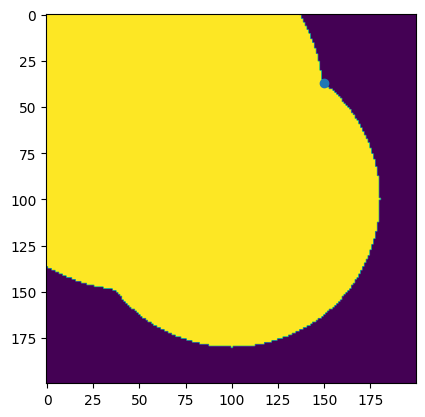

In [187]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt

bitmap = np.zeros((200, 200))
cv2.circle(bitmap, (50, 50), 100, 1, -1) # type: ignore
cv2.circle(bitmap, (100, 100), 80, 1, -1) # type: ignore
plt.imshow(bitmap)
target = np.array([100, 75])

bitmap = bitmap.transpose().astype(bool)
reachable_points = np.stack(np.meshgrid(np.arange(bitmap.shape[0]), np.arange(bitmap.shape[0])), axis=-1)[~bitmap].reshape(-1, 2)
if len(reachable_points) == 0:
    raise ValueError('No reachable points')
closest = min(reachable_points, key=lambda p: np.linalg.norm(target-p))
plt.scatter(*closest)

In [2]:
class Map:
    
    def __init__(self, pos: tuple, shape: tuple, scale: float) -> None:
        self.pos = np.array(pos, dtype=np.int16)
        self.array = np.zeros(shape, dtype=np.uint32)
        self.scale = scale


    def absolute2map(self, coords: np.ndarray) -> np.ndarray:
        topleft = np.array([self.pos[0], self.pos[1] + self.array.shape[0]*self.scale])
        x, y = (coords-topleft) / self.scale
        return np.array([-y, x])
    

    def map2absolute(self, coords: np.ndarray) -> np.ndarray:
        topleft = np.array([self.pos[0], self.pos[1] + self.array.shape[0]*self.scale])
        x, y = coords
        return np.array([y, -x]) * self.scale + topleft

    
    def get_bitmap(self) -> np.ndarray:
        bitmap = cv2.threshold(self.array.astype(np.float32), 10, 1, cv2.THRESH_BINARY)[1]
        kernel = np.zeros([int(np.ceil((0.54**2 + 0.4**2)**.5/self.scale))]*2, int)
        cv2.circle(kernel, np.array(kernel.shape)//2, kernel.shape[0]//2, 1, -1) # type: ignore
        return ~cv2.filter2D(bitmap, -1, kernel).astype(bool)
    

    def find_closest_to(self, target: np.ndarray) -> np.ndarray:
        t = self.absolute2map(target + self.pos)
        print(t)
        plt.scatter(*t)
        bitmap = self.get_bitmap().transpose().astype(bool)
        reachable_points = np.stack(np.meshgrid(np.arange(bitmap.shape[0]), np.arange(bitmap.shape[0])), axis=-1)[~bitmap].reshape(-1, 2)
        if len(reachable_points) == 0:
            raise ValueError('No reachable points')
        closest = min(reachable_points, key=lambda p: np.linalg.norm(t-p))
        return self.map2absolute(closest)
        
    
    def __contains__(self, value) -> bool:
        i = np.array(value)
        low, high = self.limits()
        return all(i >= low) and all(i < high)
    
    
    def __getitem__(self, key) -> int | np.ndarray:
        if key not in self:
            raise IndexError(f'За границами карты {key}')
        i = np.array(key)
        index = i - self.pos[:i.size]
        return self.array[*index]
    
    
    def __setitem__(self, key, value: int):
        if key not in self:
            raise IndexError(f'За границами карты {key}')
        i = np.array(key)
        index = i - self.pos[:i.size]
        self.array[*index] = value


    def limits(self) -> tuple[np.ndarray, np.ndarray]:
        return self.pos, self.pos + self.array.shape


    def update(self, other):
        if self.scale != other.scale:
            raise ValueError(f'Масштаб карт при сложении отличается: {self.scale} и {other.scale}')
        low1, high1 = self.limits()
        low2, high2 = other.limits()
        new_pos = np.min(np.vstack((low1, low2)), axis=0)
        new_high = np.max(np.vstack((high1, high2)), axis=0)
        new_array = np.zeros(new_high-new_pos, dtype=np.uint32)
        new_array[*[slice(l, h) for l, h in zip(low1-new_pos, low1-new_pos + np.array(self.array.shape))]] += self.array
        new_array[*[slice(l, h) for l, h in zip(low2-new_pos, low2-new_pos + np.array(other.array.shape))]] += other.array
        self.pos = new_pos
        self.array = new_array
        

    def show(self):
        x_min, y_max, x_max, y_min = np.concatenate(self.limits())*self.scale
        plt.imshow(self.array, cmap='gray_r', vmax=10, extent=[y_max, y_min, x_min, x_max])
        plt.gca().set_aspect('equal')
        plt.colorbar()
        plt.grid(which='both')

NameError: name 'np' is not defined

pygame-ce 2.4.0 (SDL 2.28.5, Python 3.11.5)


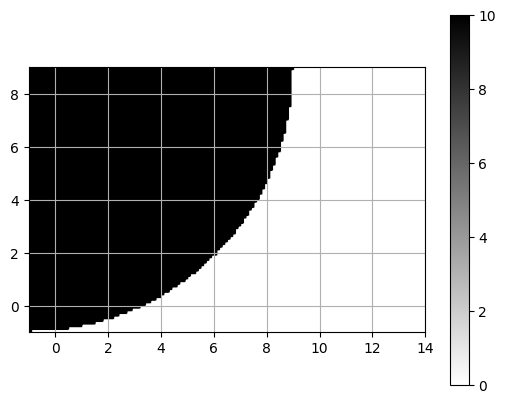

In [2]:
from navigation import Map
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt

M = Map((-10., -10.), (100, 150), 0.1)
img = M.array.astype(int)
cv2.circle(img, (0, 0), 99, 25, -1) # type: ignore
M.array = img.astype(np.uint32)
M.show()

# closest = M.find_closest_to(np.array([0, 0]))
# plt.scatter(*closest)
# closest

In [7]:
M.map2absolute(M.absolute2map(np.array([6, 1])))

array([6., 1.])

In [20]:
M.array[*np.array([30,  0])]

25